In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import torch.nn.functional as F
import sys
import os 
from data import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [2]:
# simple vgg like network
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        #Input channels = 4, output channels = 32
        self.conv1 = torch.nn.Conv2d(4, 32, kernel_size=5, stride=2)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=5, stride=2)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=2)
        self.conv4 = torch.nn.Conv2d(128, 256, kernel_size=3, stride=2)
        self.conv5 = torch.nn.Conv2d(256, 512, kernel_size=3, stride=1)
        self.avg_pool = torch.nn.AdaptiveAvgPool2d((1,1))

        #512 input features, 28 output features
        self.fc1 = torch.nn.Linear(512, 28)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.avg_pool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.sigmoid(x)
        return x

In [3]:
model = SimpleCNN()
x = torch.tensor(np.empty((8,4,512,512)), dtype=torch.float32)
y = model.forward(x)
y.shape

torch.Size([8, 28])

In [4]:
data_dir = "data/train"
train_labels = pd.read_csv('data/train.csv')
ids = train_labels.Id
onehot = [target2onehot(t) for t in train_labels.Target]
labels = dict(zip(ids, np.array(onehot)))

# Parameters
params = {'batch_size': 128,
          'shuffle': True,
          'num_workers': 16}

# Generators
ds = HmDataset(ids, labels, data_dir)
trainloader = DataLoader(ds, **params)

In [98]:
losses = []
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:1" if use_cuda else "cpu")
model.to(device)
criterion = torch.nn.BCELoss()
criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())
n_epochs = 25
for j, epoch in enumerate(range(n_epochs)):  # loop over the dataset multiple times
    losses.append([])
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader), 0):
        # get the inputs
        inputs, labels = data
        labels = labels.to(device)
        inputs = inputs.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        losses[-1].append(loss.item())
        running_loss += loss.item()
#         if i % 100 == 99:    # print every 100 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 100))
#             running_loss = 0.0
        
    print("Epoch %d average loss %f" % (j, np.mean(losses[-1])))

print('Finished Training')

  0%|          | 0/243 [00:00<?, ?it/s]

Epoch 0 average loss 0.115782


  0%|          | 0/243 [00:00<?, ?it/s]

Epoch 1 average loss 0.108375


  0%|          | 0/243 [00:00<?, ?it/s]

Epoch 2 average loss 0.100143


  0%|          | 0/243 [00:00<?, ?it/s]

Epoch 3 average loss 0.091260


  0%|          | 0/243 [00:00<?, ?it/s]

Epoch 4 average loss 0.080400


  0%|          | 0/243 [00:00<?, ?it/s]

Epoch 5 average loss 0.067966


  0%|          | 0/243 [00:00<?, ?it/s]

Epoch 6 average loss 0.055941


  0%|          | 0/243 [00:00<?, ?it/s]

Epoch 7 average loss 0.044762


  0%|          | 0/243 [00:00<?, ?it/s]

Epoch 8 average loss 0.035178


  0%|          | 0/243 [00:00<?, ?it/s]

Epoch 9 average loss 0.028510


  0%|          | 0/243 [00:00<?, ?it/s]

Epoch 10 average loss 0.024101


  0%|          | 0/243 [00:00<?, ?it/s]

Epoch 11 average loss 0.018688


  0%|          | 0/243 [00:00<?, ?it/s]

Epoch 12 average loss 0.017344


  0%|          | 0/243 [00:00<?, ?it/s]

Epoch 13 average loss 0.015802


  0%|          | 0/243 [00:00<?, ?it/s]

Epoch 14 average loss 0.014325


  0%|          | 0/243 [00:00<?, ?it/s]

Epoch 15 average loss 0.015575


  0%|          | 0/243 [00:00<?, ?it/s]

Epoch 16 average loss 0.011947


  0%|          | 0/243 [00:00<?, ?it/s]

Epoch 17 average loss 0.009941


  0%|          | 0/243 [00:00<?, ?it/s]

Epoch 18 average loss 0.010540


  0%|          | 0/243 [00:00<?, ?it/s]

Epoch 19 average loss 0.009688


  0%|          | 0/243 [00:00<?, ?it/s]

Epoch 20 average loss 0.007668


  0%|          | 0/243 [00:00<?, ?it/s]

Epoch 21 average loss 0.009488


  0%|          | 0/243 [00:00<?, ?it/s]

Epoch 22 average loss 0.009904


  0%|          | 0/243 [00:00<?, ?it/s]

Epoch 23 average loss 0.009752


100%|██████████| 243/243 [01:18<00:00,  3.08it/s]

Epoch 24 average loss 0.007321
Finished Training


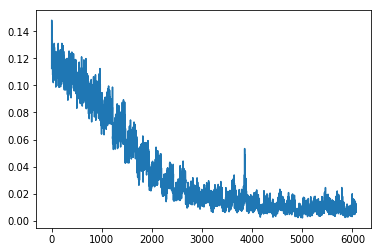

In [99]:
train_loss = np.array(losses)
plt.plot(train_loss.flatten())

In [108]:
pred = None
gt = None
model.eval()
with torch.no_grad():
    valloader = DataLoader(ds, batch_size=64, shuffle=False, num_workers=8)
    for i, data in enumerate(tqdm(valloader)):
        x, t = data
        x = x.to(device)
        t = t.to(device)
        y = model(x).detach().cpu().numpy()
        if i > 0:
            pred = np.vstack([pred, y])        
            gt = np.vstack([gt, t.cpu().numpy()])
        else:
            pred = y
            gt = t.cpu().numpy()
            
f1_score(gt, (pred > 0.2).astype(int), average='macro')

100%|██████████| 486/486 [01:01<00:00,  7.85it/s]


In [109]:
f1_score(gt, (pred > 0.2).astype(int), average='macro')

0.9662582230038972

In [102]:
sub_df = pd.read_csv('data/sample_submission.csv')
test_tgt = dict(zip(sub_df.Id, np.zeros(len(sub_df))))
test_ds = HmDataset(sub_df.Id, test_tgt, 'data/test')

In [103]:
pred = None
model.eval()
with torch.no_grad():
    valloader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=8)
    for i, data in enumerate(tqdm(valloader)):
        x, t = data
        x = x.to(device)
        y = model(x).detach().cpu().numpy()
        if i > 0:
            pred = np.vstack([pred, y])        
        else:
            pred = y

pred = (pred > 0.2).astype(int)

100%|██████████| 183/183 [00:22<00:00,  8.18it/s]


In [104]:
sub_df.Predicted = [' '.join(map(str, pred[i].nonzero()[0])) for i,x in enumerate(pred)]
sub_df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,1 5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 2 21 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 7
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,


In [106]:
sub_df.to_csv('submision.csv', index=False)